In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.1 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=6a404ebdb044732a3418bc0c75db37a4ac02cfbb641e0769ea35c1db2ae86623
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b0c7effa31dfe5ab147e6b6b6b0a45566ba7a46f417be6c014eb0364378bf832
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [2]:
from PIL import Image
import numpy as np
from pathlib import Path
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
import torchmetrics
from segmentation_models_pytorch.utils.metrics import IoU
from torch.optim import Adam

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
class CONFIG():
    seed = 42
    img_size = 224
    batch_size =  8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 40
    train_unet = False

np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)

train_csv = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
imgs_path_1 = Path('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1')
imgs_path_2 = Path('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2')
masks_path = Path('/kaggle/input/ham10000-lesion-segmentations/HAM10000_segmentations_lesion_tschandl')
train_hf = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')


In [4]:
class ImageTrainDataset:
    def __init__(self, df, transform=None,mask_transform=None, mode='train'):
        self.df = df
        self.mode = mode
        self.keys = self.df['lesion_id'].unique()
        
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.df = self.df[['lesion_id', 'image_id']].drop_duplicates(subset='lesion_id')
        self.df_train = self.df[:int(len(df) * 0.7)].reset_index()
        self.df_val = self.df[int(len(df) * 0.7):int(len(df) * 0.9)].reset_index()
        self.df_test = self.df[int(len(df) * 0.9):].reset_index()
        
        self.ids_train = self.df_train['image_id'].values
        self.ids_val = self.df_val['image_id'].values
        self.ids_test = self.df_test['image_id'].values

        
        self.transform = transform
        self.mask_transform = mask_transform
        
    def __len__(self):
        if(self.mode == 'train'):
            return len(self.df_train) 
        elif(self.mode == 'eval'):
            return len(self.df_val)
        else:
            return len(self.df_test) 

    def __getitem__(self, idx):
        if(self.mode == 'train'):
            df = self.df_train
            isic_ids = self.ids_train
        elif(self.mode == 'eval'):
            df = self.df_val
            isic_ids = self.ids_val

        elif(self.mode == 'test'):
            df = self.df_test
            isic_ids = self.ids_test
        
        idx = idx % len(df)
        image_id = isic_ids[idx]
        img_path = imgs_path_1 / (image_id + '.jpg') if int(image_id[5:]) < 29306 else imgs_path_2 / (image_id + '.jpg')
        img = Image.open(img_path)
        mask = Image.open(masks_path / (image_id + '_segmentation.png'))
        if self.transform:
            img = self.transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask
    
    def eval(self):
        self.mode = 'eval'
    def train(self):
        self.mode = 'train'
    def test(self):
        self.mode = 'test'

In [5]:
train = pd.read_csv(train_csv, low_memory=False)

img_transform = transforms.Compose([
    transforms.Resize((CONFIG.img_size, CONFIG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Resize((CONFIG.img_size, CONFIG.img_size)),
    transforms.ToTensor(),
])


dataset = ImageTrainDataset(train, img_transform, mask_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

val_dataset = ImageTrainDataset(train, img_transform, mask_transform)
val_dataset.eval()
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

test_dataset = ImageTrainDataset(train, img_transform, mask_transform)
test_dataset.eval()
test_dataloader = DataLoader(test_dataset,batch_size=8, shuffle=True, num_workers=4)


In [6]:
model = Unet(encoder_name="resnet34", 
             encoder_weights="imagenet", 
             in_channels=3,              
             classes=1)    
model.to(CONFIG.device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.9MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [7]:
criterion = DiceLoss(mode='binary') 
optimizer = Adam(model.parameters(), lr=0.001)
metric_fn = IoU(threshold=0.5)

In [8]:
import time

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


best_loss = np.inf
best_model = model.state_dict()


if CONFIG.train_unet:
    for epoch in range(CONFIG.epochs):
        start_time = time.time()  # 
        train_loss = train_one_epoch(model, dataloader, criterion, optimizer, CONFIG.device)
        val_loss = validate(model, val_dataloader, criterion, CONFIG.device)

        end_time = time.time()
        epoch_time = end_time - start_time

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            counter = 0

        print(f"Epoch {epoch+1}/{CONFIG.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds")
        
else:
    best_model = torch.load('/kaggle/input/unet_trained/pytorch/default/3/unet40epoch911best.pt')


/tmp/ipykernel_36/3235727439.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('/kaggle/input/unet_trained/pytorch/default/3/unet40epoch911best.pt

In [9]:
torch.save(best_model, 'best_model.pt')
model.load_state_dict(best_model)

<All keys matched successfully>

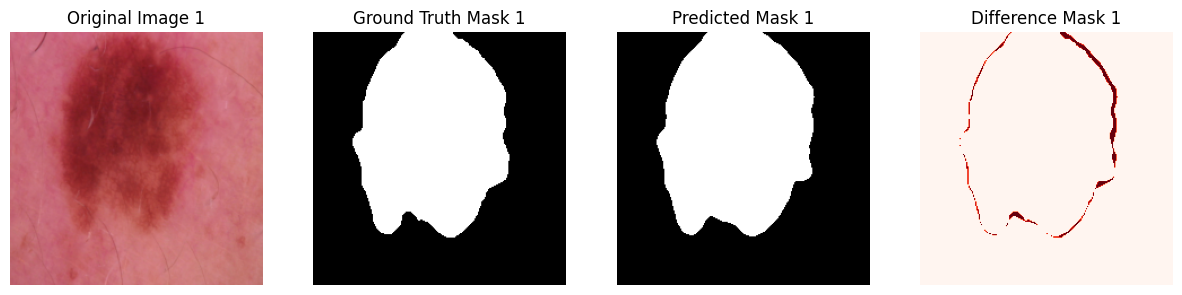

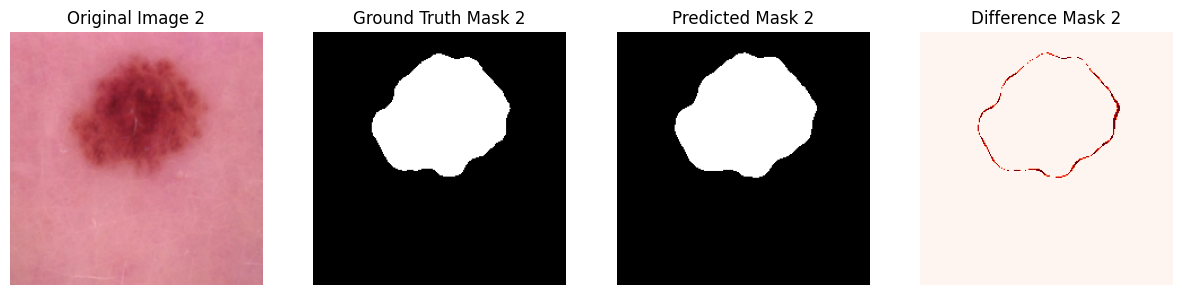

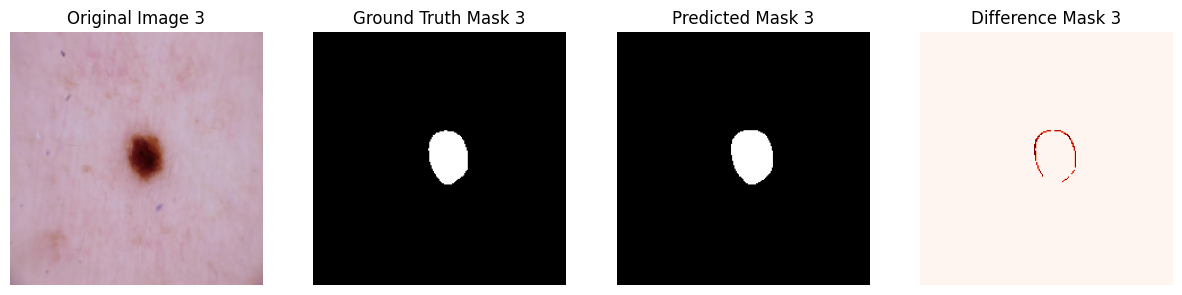

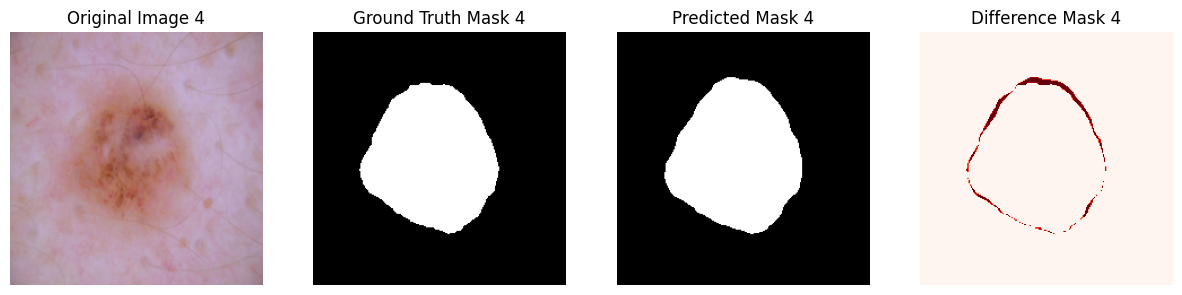

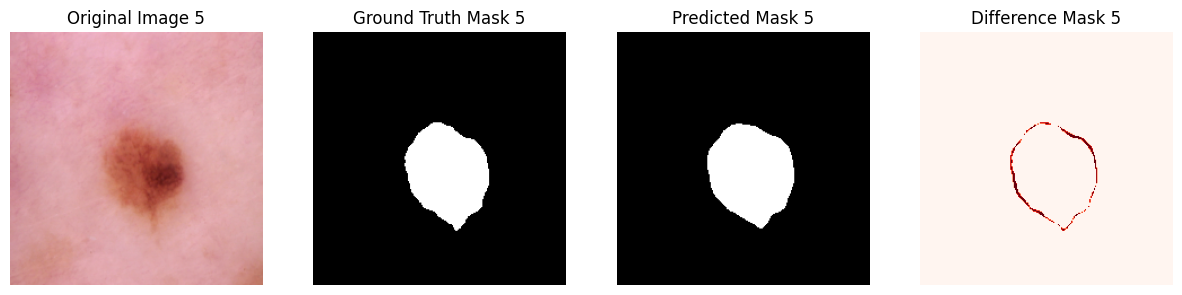

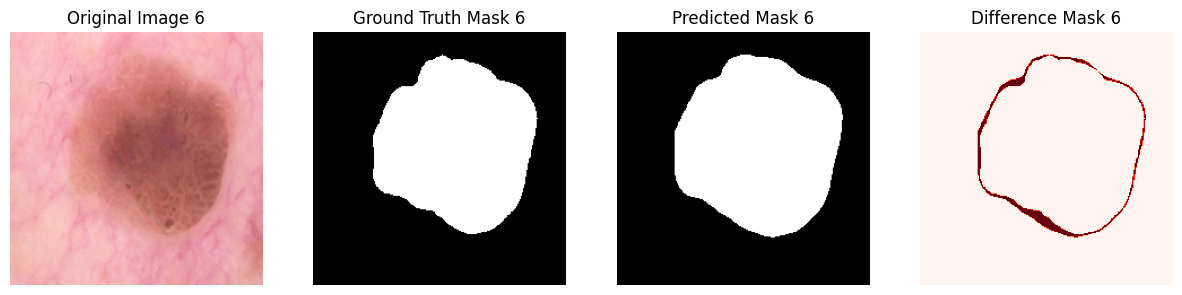

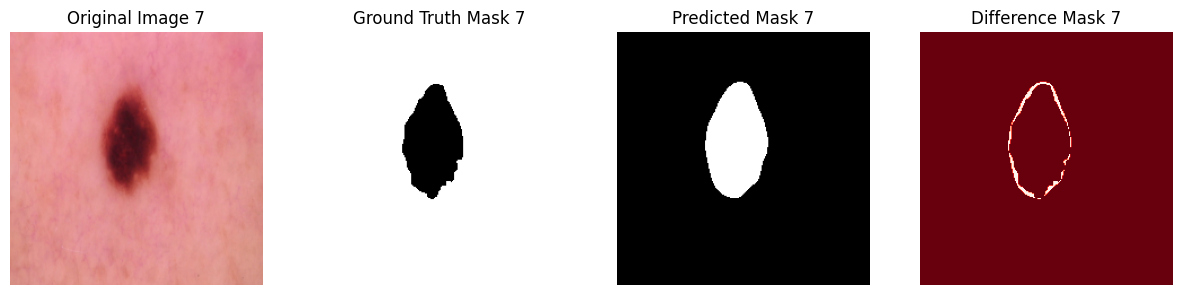

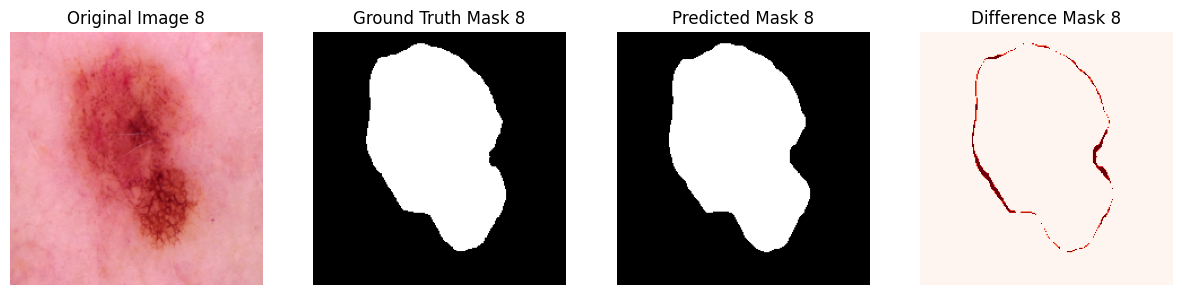

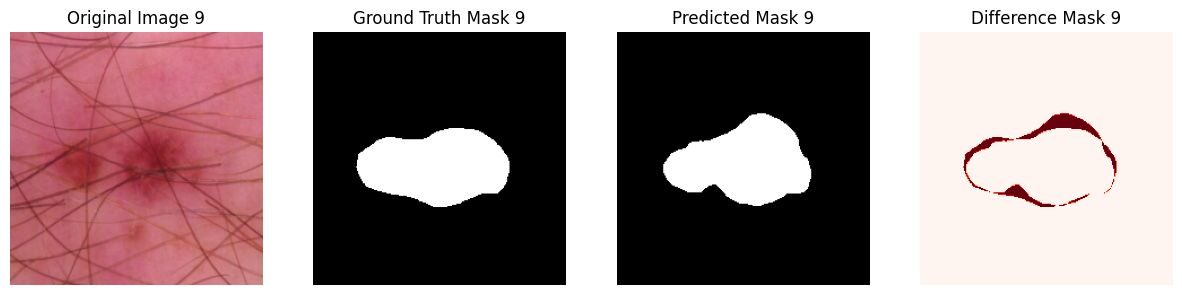

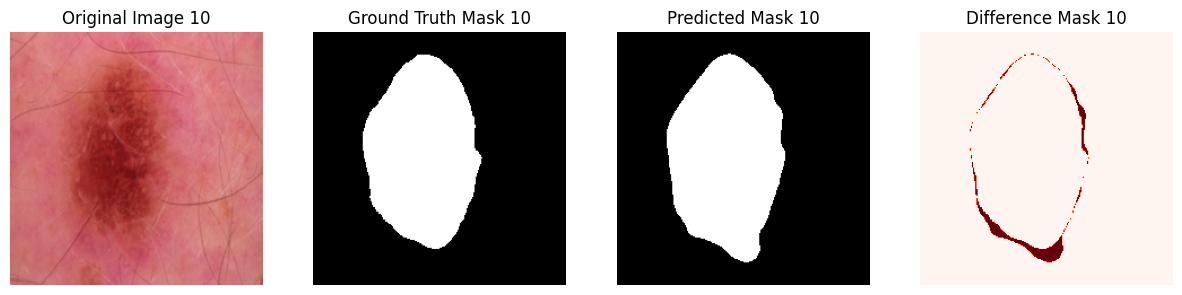

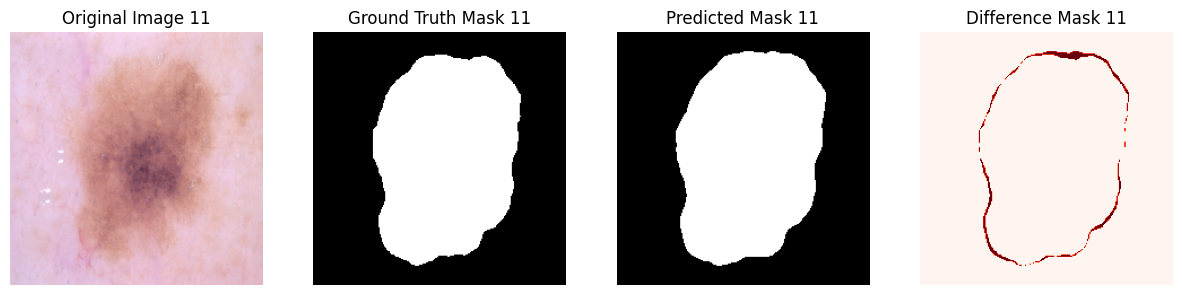

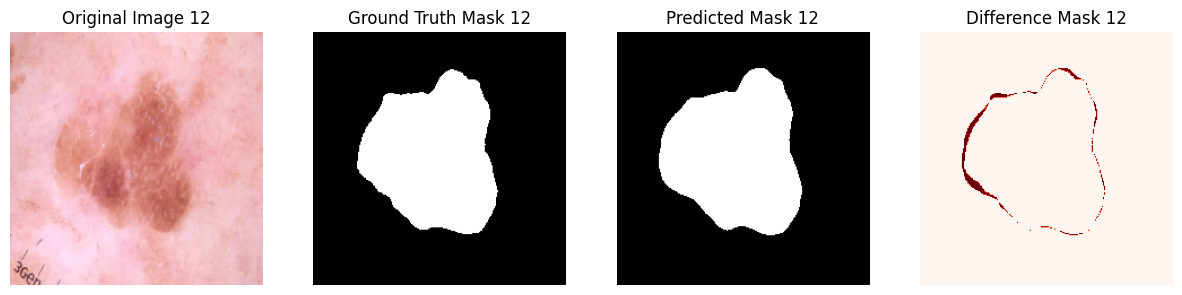

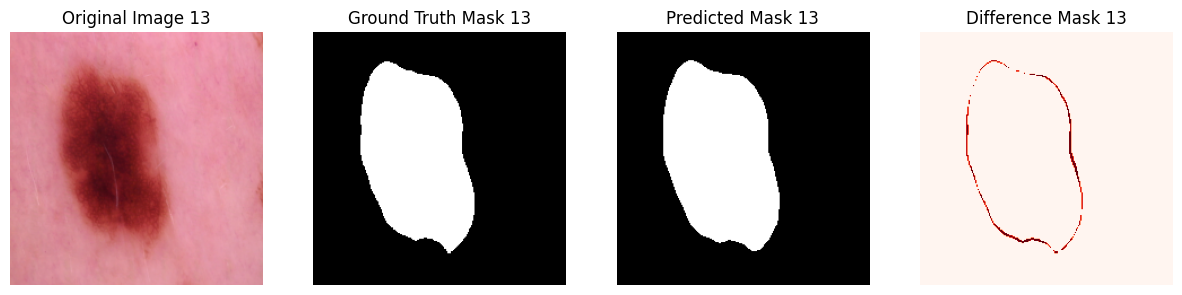

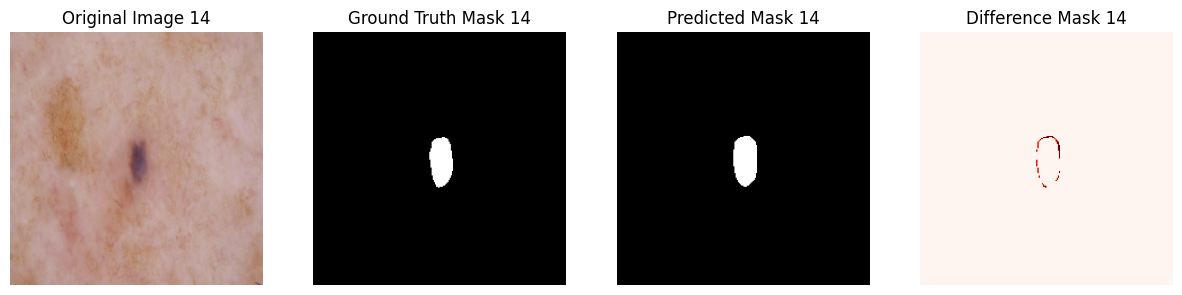

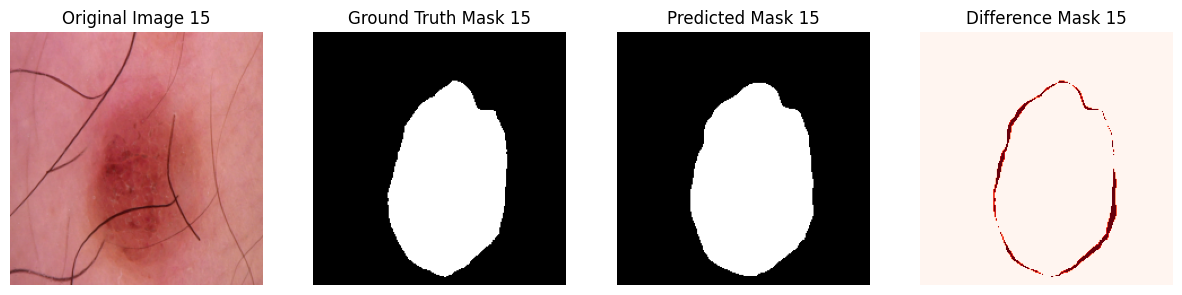

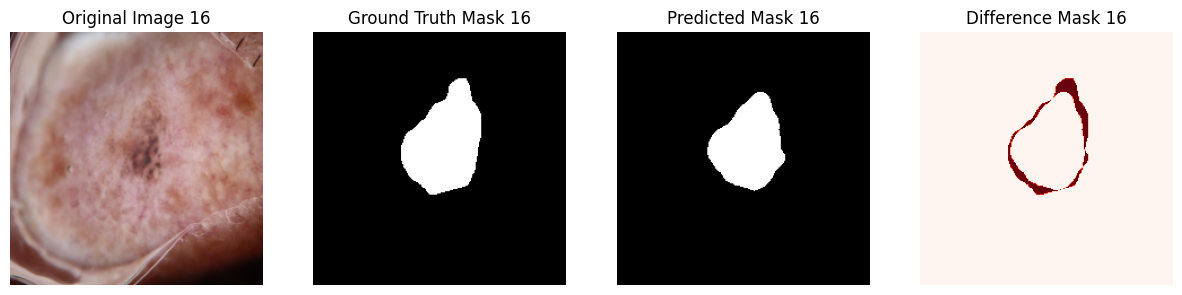

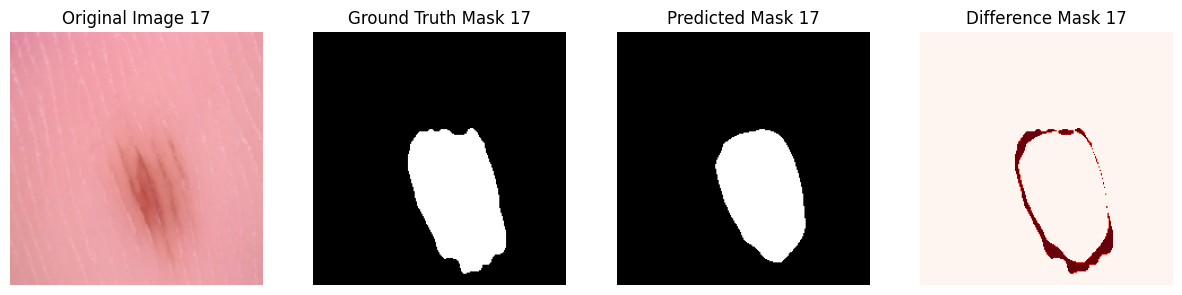

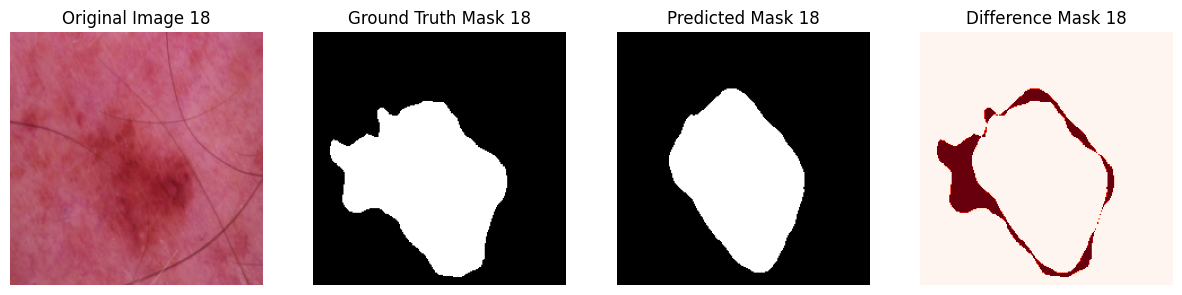

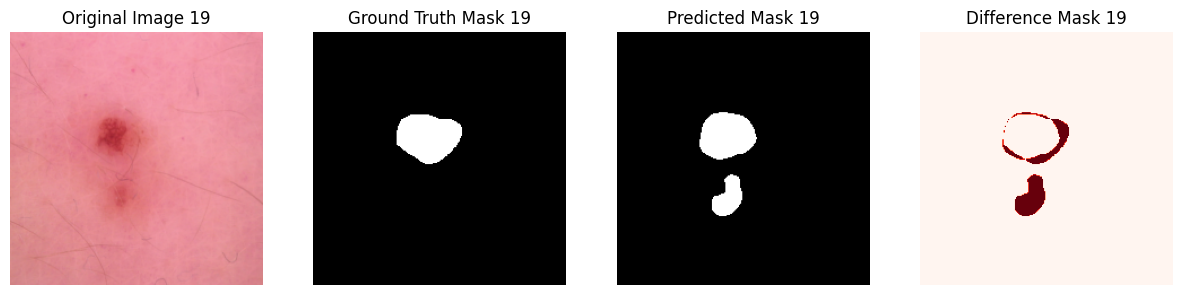

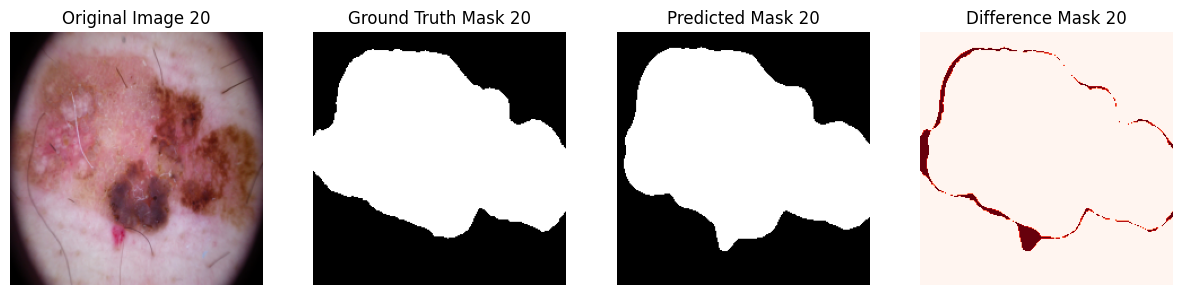

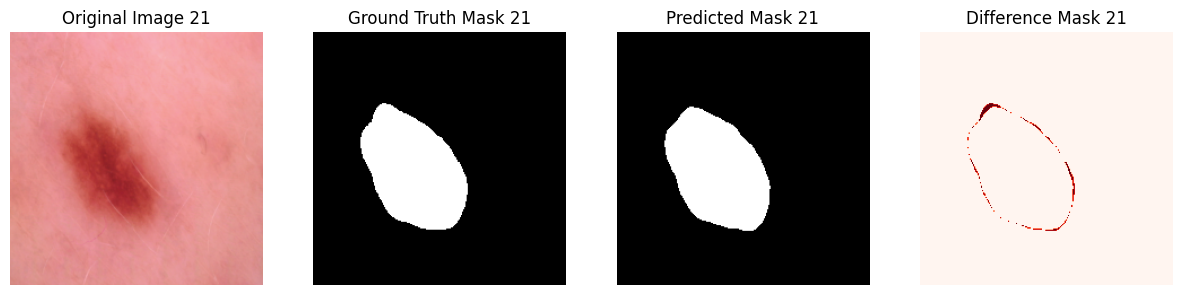

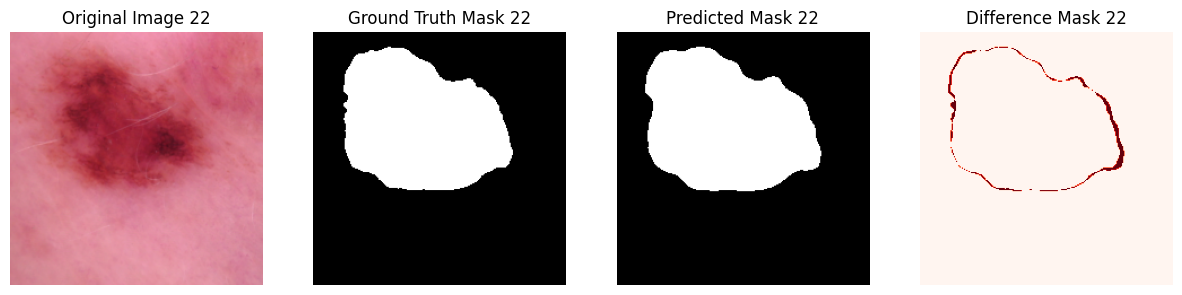

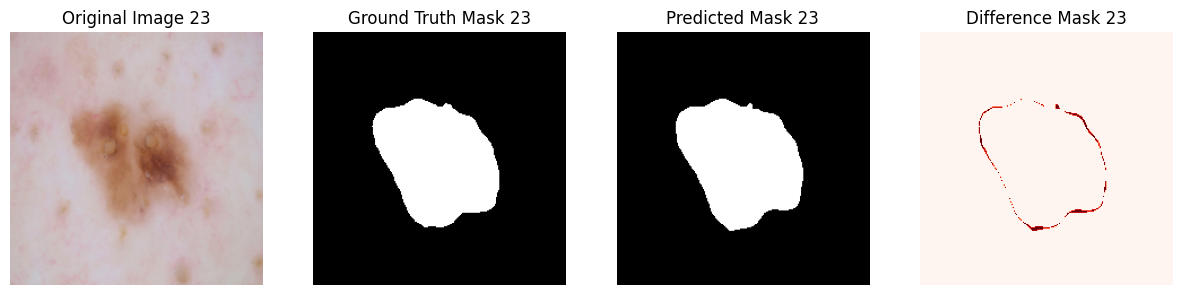

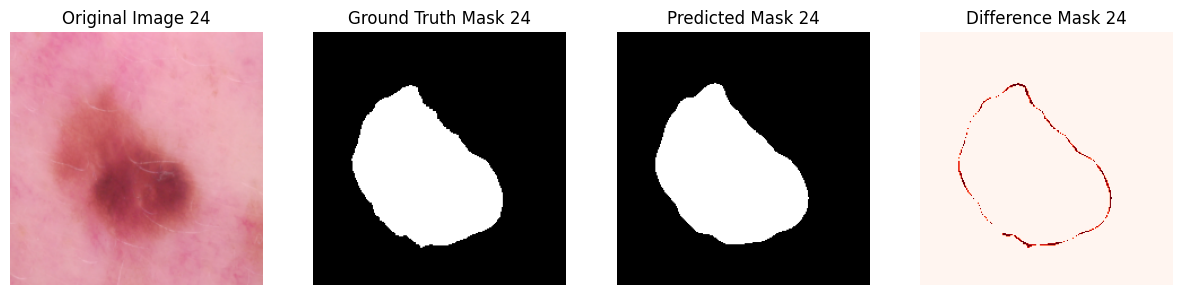

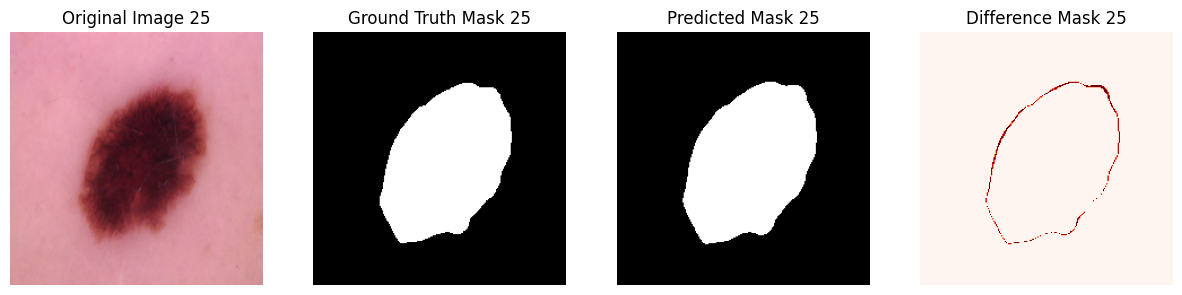

Dice Score: 0.9114
IoU: 0.8477


(0.9113839063151129, 0.8477082339854076)

In [13]:
dice = torchmetrics.Dice(num_classes=1, multiclass=False).to(CONFIG.device)
iou = torchmetrics.JaccardIndex(num_classes=1, task='binary').to(CONFIG.device)

def test_and_visualize(model, dataloader, device):
    model.eval()
    dice_scores = []
    iou_scores = []
    num_images_to_display = 25  
    displayed_images = 0 
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).long()
            masks = masks.long()  

            
            dice_score = dice(preds, masks)
            iou_score = iou(preds, masks)
            
            dice_scores.append(dice_score.item())
            iou_scores.append(iou_score.item())

            if displayed_images < num_images_to_display:
                img = images[0].cpu()
                for t, m, s in zip(img, (0.5,0.5,0.5), (0.5,0.5,0.5)):
                    t.mul_(s).add_(m)
                
                img = img.numpy().transpose(1, 2, 0)  
                img = (img * 255).astype(np.uint8)  

                
        
                ground_truth = masks[0].cpu().numpy().squeeze()
                prediction = (preds[0].cpu().numpy().squeeze() > 0.5).astype(np.uint8)
                difference_mask = np.abs(ground_truth - prediction)

                fig, axs = plt.subplots(1, 4, figsize=(15, 5))
                idx += 1
                axs[0].imshow(img)
                axs[0].set_title(f'Original Image {idx}')
                axs[1].imshow(ground_truth, cmap='gray')
                axs[1].set_title(f'Ground Truth Mask {idx}')
                axs[2].imshow(prediction, cmap='gray')
                axs[2].set_title(f'Predicted Mask {idx}')
                axs[3].imshow(difference_mask, cmap='Reds')
                axs[3].set_title(f'Difference Mask {idx}')

                for ax in axs:
                    ax.axis('off')
                plt.show()

                displayed_images += 1
    
    avg_dice = np.mean(dice_scores) if dice_scores else 0
    avg_iou = np.mean(iou_scores) if iou_scores else 0
    
    print(f"Dice Score: {avg_dice:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    
    return avg_dice, avg_iou

test_and_visualize(model, test_dataloader, CONFIG.device)

In [ ]:
import random
import cv2
import h5py
from io import BytesIO


img_transform = transforms.Compose([
    transforms.Resize((CONFIG.img_size, CONFIG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
isic_ids = df['isic_id'].values
sampled_ids = random.sample(list(isic_ids), 50)
fp_hdf = h5py.File(train_hf, mode="r")
imgs = []
for id in sampled_ids:
    image = Image.open(BytesIO(fp_hdf[id][()])).convert('RGB')
    
    input_tensor = img_transform(image).unsqueeze(0)
    
    imgs.append(input_tensor)

In [ ]:
model.eval()
img_results = []
with torch.no_grad():
    for img in imgs:
        img = img.to(CONFIG.device)
        output_mask = model(img).cpu().squeeze().numpy()
        output_mask = (output_mask > 0.5).astype(np.uint8)
        output_mask_image = Image.fromarray(output_mask[0], mode='L')
        img_results.append(output_mask)
        
num_images_to_display = 5
for i in range(min(num_images_to_display, len(imgs))):
    img = imgs[i][0]
    for t, m, s in zip(img, (0.5,0.5,0.5), (0.5,0.5,0.5)):
        t.mul_(s).add_(m)
    img = img.cpu().numpy() 
    img = np.transpose(img, (1, 2, 0)) 

    result = img_results[i]
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap="gray")  
    plt.title("U-Net Segmentation")
    plt.axis("off")
    
    plt.show()